In [1]:
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
from scipy.stats import binned_statistic

In [2]:
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import seaborn as sns

In [3]:
col_names = ['NZGDID', 'depth', 'qc', 'fs', 'u2']
#depth is in meter.
#qc, fs, and u2 are in MPa.
df = pd.read_csv('CPT_Data_20160323_plus_trench.csv', names=col_names)
print(f'The data includes {len(df.NZGDID.unique())} CPT soundings')

The data includes 9243 CPT soundings


In [4]:
# loading the dataset with liquefaciton observation labels
obs_df = pd.read_csv('CPT_obs_mapping.csv')
print(f'The summary of {len(obs_df)} CPT profiles')
obs_df.head()

The summary of 9243 CPT profiles


,CGDID,TTGDID,CPTID,easting__N,northing__,Investigat,Investig_1,Reference,PreDrill_D,Depth_of_T,Groundwate,Measured_D,ConeID,Known_Issu,Post_Groun,obs_class
0,36060,39427.0,34187.0,1570418.000,5181007.000,CPT,NaN,CPT 1,0.0,22.68,1.0,1.60,1701-2525,NaN,0,0.0
1,13110,13110.0,10835.0,1570431.900,5181833.100,CPT,NaN,NaN,0.0,9.33,0.0,0.00,C10CFIIP.G23,NaN,0,0.0
2,37673,40363.0,35245.0,1570444.000,5180949.000,CPT,NaN,238388,0.0,10.20,1.0,1.05,4473,NaN,0,0.0
3,37674,40364.0,35246.0,1570465.000,5180951.000,CPT,NaN,238388,0.0,10.96,1.0,1.05,4473,NaN,0,0.0
4,45901,45085.0,43632.0,1570468.193,5180963.458,CPT,NaN,33249-CPT03,0.0,19.98,1.0,1.00,1701-2500,NaN,0,0.0


In [5]:
# loading data that selected by Dr.Durante
metadata = pd.read_csv('CPT_Metadata.csv')
print(f'{len(metadata)} CPT data are selected by Dr.Durante')
metadata.head()

1702 CPT data are selected by Dr.Durante


,FID,CPT,predrill (m),L (m),Depth of Test (m),GWT (m),PGA (g),Lat,Long,CH_EW_RMSE,CH_NS_RMSE,CH_APL_mod (m),Rrup,CH_APL,Elevation (m),Slope_5m (%),River_Dir (deg)
0,2445,4,0.8,551.746299,39.2,2.63418,0.51,-43.511633,172.712160,0.183362,-0.015059,0.183979,2.746067,0.183979,1.94957,0.17468,19.15531
1,2084,28,1.2,394.938416,18.4,2.74343,0.49,-43.508305,172.707421,-0.029763,0.012632,0.032333,3.236562,0.032333,3.03307,0.53177,36.44637
2,2287,29,1.2,421.836623,27.9,2.55272,0.50,-43.509731,172.710120,-0.160100,0.026523,0.162282,2.997026,0.162282,2.16001,0.71861,25.73362
3,2440,30,1.2,365.285885,38.7,2.21710,0.50,-43.509829,172.712120,-0.015150,-0.028252,0.032058,2.909735,0.032058,1.97108,0.48305,20.93315
4,2262,31,1.2,195.738070,38.2,1.99977,0.49,-43.507378,172.709962,-0.159462,0.064285,0.171932,3.216153,0.171932,1.95014,0.72001,29.37664


In [6]:
# replace the sparse GWT data in obs_df with the measured value in metadata
count = 0
for CPTID in metadata.CPT.values:
    #print(CPTID)
    if obs_df[obs_df['TTGDID']==CPTID]['Groundwate'].values == 0:
        obs_df.loc[:,'Groundwate'][obs_df['TTGDID']==CPTID] = 2
        obs_df.loc[:,'Measured_D'][obs_df['TTGDID']==CPTID] = metadata[metadata['CPT'] == CPTID]['GWT (m)'].values
        #print(obs_df[obs_df['TTGDID']==CPTID]['Measured_D'])
        count +=1
print(count)

C:\Users\Clawsy\AppData\Local\Temp/ipykernel_16468/1202007898.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df.loc[:,'Groundwate'][obs_df['TTGDID']==CPTID] = 2
C:\Users\Clawsy\AppData\Local\Temp/ipykernel_16468/1202007898.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  obs_df.loc[:,'Measured_D'][obs_df['TTGDID']==CPTID] = metadata[metadata['CPT'] == CPTID]['GWT (m)'].values


1071


C:\Users\Clawsy\AppData\Local\Temp/ipykernel_16468/1202007898.py:5: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if obs_df[obs_df['TTGDID']==CPTID]['Groundwate'].values == 0:


In [7]:
# drop the data that don't have liquefaction observation
obs_df.dropna(subset='obs_class', inplace=True)
# drop the data that don't have GWT
obs_df.dropna(subset='Groundwate', inplace=True)
obs_df = obs_df[obs_df['Groundwate']!=0]

print(f'{len(obs_df)} CPT data are left')

2823 CPT data are left


In [8]:
df = df[df.NZGDID.isin(obs_df.TTGDID)]
obs_df = obs_df[obs_df.TTGDID.isin(df.NZGDID.unique())]
print(f'{len(df.NZGDID.unique())} CPT data are finally selected')

2823 CPT data are finally selected


In [9]:
# round the depth values to 0.01m
df.depth = df.depth.round(decimals=2)
# set min caps for qc and fs
df.qc = df.qc.clip(lower = 0.01, upper = None)
df.fs = df.fs.clip(lower = 0.001, upper = None)

# change qc, fs, u2 into kPa unit
df.qc *= 1000
df.fs *= 1000

Calculate the approximated unit weight based on Robertson and Cabal 2010

In [10]:
pa = 101 # atmospheric pressure in kPa
gamma_w = 9.81 # unit weight of water

## Unit weight estimation
![alt text](approximate_gamma.png)

In [11]:
gamma = gamma_w*(0.27*(np.log10(100*df.fs/df.qc)) + 0.36*(np.log10(df.qc/pa)) + 1.236)
gamma = np.clip(gamma, a_min=1.5*gamma_w, a_max=2.0*gamma_w)
# should we consider upper and lower caps for estimated gamma?
df['gamma'] = gamma
print(f'min gamma: {gamma.min():.2f} kN/m^3')
print(f'max gamma: {gamma.max():.2f} kN/m^3')

min gamma: 14.71 kN/m^3
max gamma: 19.62 kN/m^3


## Ic and qc1ncs calculation
![alt text](Ic_qc1ncs.png)

In [12]:
def CPT_interpret(qc, fs, gamma, depth, GWT):
    
    total_stress = integrate.cumtrapz(gamma, depth, initial=0)
    #total_stress = gamma*depth
    u = gamma_w * np.clip((depth - GWT), a_min=0, a_max=None)
    eff_stress = total_stress - u
    eff_stress = np.clip(eff_stress, a_min=0.001, a_max=None)

    n_new = np.ones(len(qc))
    n_old = np.zeros(len(qc))
    # this was determined through trial and error with the entire database,
    # smaller values lead to convergence issues with some of the CPTs
    isConverge = True
    iteration = 0
    while np.any(abs(n_new - n_old) > 0.003) == 1:
        n_old = n_new
        F = np.clip(100*fs/(qc - total_stress), a_min=0, a_max=None)
        
        Q = np.clip((qc-total_stress)/pa * np.power(pa/eff_stress, n_new), a_min=0, a_max=None)
        #Q = np.multiply((qc - total_stress) / pa, np.power(pa / eff_stress, n_new))
        Ic = np.sqrt((3.47 - np.log10(Q))**2 + (1.22 + np.log10(F))**2)
        Ic = np.real(Ic)
        n_new = 0.3 * (Ic-1.64) + 0.5
        n_new[Ic <= 1.64] = 0.5
        n_new[(Ic >= 3.3) | (n_new > 1.0)] = 1.0
        n_new[eff_stress > 300] = 1
        iteration+=1
        if iteration > 30:
            print('not converging')
            isConverge = False
            break

    # 0.07 is the curve fitting parameter used by Robinson et al 2013 for liquefiable soils along
    # the Avon River in Christchurch, New Zealand
    FC = 80 * (Ic + 0.07) - 137
    FC[FC < 0] = 0
    FC[FC > 100] = 100

    # procedure for calculating the normalized tip resistance (qc1n) and clean sand corrected normalized tip resistance (qc1ncs)
    # from Boulanger and Idriss 2014
    m = 0.7
    Cn = np.clip((pa/eff_stress)**m, a_min=None, a_max=1.7)
    qc1n = Cn*qc/pa
    delta_qc1n = (11.9 + qc1n/14.6)*np.exp(1.63 - 9.7/(FC+2) - (15.7/(FC+2))**2)
    qc1ncs_new = qc1n + delta_qc1n
    qc1ncs_old = np.zeros(len(qc))

    while np.any(abs(qc1ncs_new-qc1ncs_old) > 0.0001) == 1:
        qc1ncs_old = qc1ncs_new
        m = 1.338 - 0.249 * qc1ncs_new**0.264
        Cn = np.clip((pa/eff_stress)**m, a_min=None, a_max=1.7)
        qc1n = Cn*qc/pa
        delta_qc1n = (11.9 + qc1n/14.6)*np.exp(1.63 - 9.7/(FC+2) - (15.7/(FC+2))**2)
        qc1ncs_new = np.clip((qc1n + delta_qc1n), a_min=21, a_max=254)
    qc1ncs = qc1ncs_new
    
    return qc1n, qc1ncs, Ic, isConverge

In [13]:
df['qc1ncs'] = 0
df['qc1n'] = 0
df['Ic'] = 0

In [14]:
for row in tqdm(obs_df.iterrows(), total=obs_df.shape[0]):
    ID = row[1]['TTGDID']
    GWT = row[1]['Measured_D']
    qc1n, qc1ncs, Ic, isConverge = CPT_interpret(df.qc[df.NZGDID==ID],
                               df.fs[df.NZGDID==ID],
                               df.gamma[df.NZGDID==ID],
                               df.depth[df.NZGDID==ID],
                               GWT=GWT)
    if not isConverge:
        print(f'ID: {ID}')
    df.loc[df.NZGDID==ID,'qc1ncs'] = qc1ncs
    df.loc[df.NZGDID==ID,'qc1n'] = qc1n
    df.loc[df.NZGDID==ID,'Ic'] = Ic

  0%|          | 0/2823 [00:00<?, ?it/s]

D:\Anaconda\envs\Lateraldispl\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


not converging
ID: 26080.0
not converging
ID: 27343.0


In [15]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

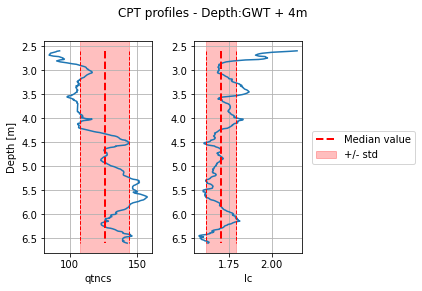

qtcns median (std) is 125.78 (18.16)
Ic median (std) is 1.70 (0.09)


In [16]:
ID = 89
GWT = obs_df[obs_df.TTGDID==ID]['Measured_D'].values[0]
mask = (df.depth[df.NZGDID==ID]>=GWT) & (df.depth[df.NZGDID==ID]<=(GWT+4))
#create dataset with dimensionless quantities
#d = {'Depth': depth, 'Fr': F, 'Qtn':qc1n ,'Qtn_cs':qc1ncs, 'Ic':Ic}
d = {'Depth': df.depth[df.NZGDID==ID][mask], 'Qtn_cs':df.qc1ncs[df.NZGDID==ID][mask], 'Ic':df.Ic[df.NZGDID==ID][mask]}

CPT_data = pd.DataFrame(data=d)

Depth=CPT_data.values[:,0]
Qtncs=CPT_data.values[:,1]
Ic=CPT_data.values[:,2]

stat = CPT_data.agg(['median','std'])
Qtncs_med = stat.values[0,1]
Qtncs_std = stat.values[1,1]
Ic_med = stat.values[0,2]
Ic_std = stat.values[1,2]

Qtncs_val = [Qtncs_med - Qtncs_std, Qtncs_med + Qtncs_std]
y = [Depth[0], Depth[-1]]

Q_pl = [Qtncs_med,Qtncs_med]
Q_pl_min = [Qtncs_med - Qtncs_std,Qtncs_med - Qtncs_std]
Q_pl_max = [Qtncs_med + Qtncs_std,Qtncs_med + Qtncs_std]

Ic_pl = [Ic_med,Ic_med]
Ic_pl_min = [Ic_med - Ic_std,Ic_med - Ic_std]
Ic_pl_max = [Ic_med + Ic_std,Ic_med + Ic_std]

plt.subplots(tight_layout=True)

plt.subplot(121)
plt.plot(Qtncs,Depth)# plotting the initial datapoints 
plt.plot(Q_pl,y, color ='red', linestyle='dashed',linewidth=2)
plt.plot(Q_pl_min,y, Q_pl_max, y, color ='red', linestyle='dashed',linewidth=1)
plt.xlabel('qtncs')
plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.grid(True)
# Filling between line y3 and line y4
plt.axvspan(Q_pl_min[0], Q_pl_max[0], ymin = 0, ymax = 1, color ='red', alpha = 0.25)

plt.subplot(122)
plt.plot(Ic,Depth)# plotting the initial datapoints 
plt.plot(Ic_pl,y, color ='red', linestyle='dashed',linewidth=2, label='Median value')
plt.plot(Ic_pl_min,y, Ic_pl_max, y, color ='red', linestyle='dashed',linewidth=1)
plt.xlabel('Ic')
#plt.ylabel('Depth [m]')
plt.gca().invert_yaxis()
plt.grid(True)
# Filling between line y3 and line y4
plt.axvspan(Ic_pl_min[0], Ic_pl_max[0], ymin = 0, ymax = 1, color ='red', alpha = 0.25, label='+/- std')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

#plt.subplots_adjust(top=0.92, bottom=0.08, left=0.050, right=0.95, hspace=0.25, wspace=0.4)
plt.suptitle('CPT profiles - Depth:GWT + 4m',y=1.0)

plt.show() 

print('qtcns median (std) is %.2f (%.2f)' %(Qtncs_med,Qtncs_std))
print('Ic median (std) is %.2f (%.2f)' %(Ic_med,Ic_std))

# Bins process and dimension reduction

## start and final depth of CPT profile

In [19]:
start_depth = []
end_depth = []
for ID in tqdm(df.NZGDID.unique()):
    start_depth.append(min(df.depth[df.NZGDID==ID]))
    end_depth.append(max(df.depth[df.NZGDID==ID]))    

  0%|          | 0/2823 [00:00<?, ?it/s]

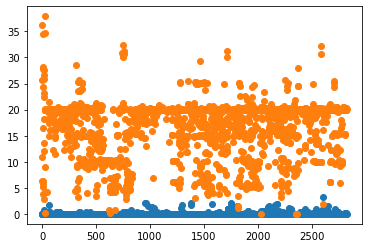

In [20]:
x = np.arange(len(df.NZGDID.unique()))
plt.scatter(x, start_depth)
plt.scatter(x, end_depth)

In [22]:
sum(np.array(end_depth)>=19)

1730

## Sampling rate = 0.1m

In [52]:
bins = 200
min_depth = 0
max_depth = 20
statistic = np.nanmean
# mean, std, median, count, sum, min, max, user-defined function
binned_qc1ncs = []
binned_qc1n = []
binned_Ic = []

mean_qc1ncs = []
mean_qc1n = []
mean_Ic = []
Norm_GWT = []
for ID in tqdm(df.NZGDID.unique()):
    
    binned_qc1ncs.append(binned_statistic(df.depth[df.NZGDID==ID], df.qc1ncs[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)
    
    binned_qc1n.append(binned_statistic(df.depth[df.NZGDID==ID], df.qc1n[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)
    
    binned_Ic.append(binned_statistic(df.depth[df.NZGDID==ID], df.Ic[df.NZGDID==ID], 
                                          statistic=statistic, 
                                          bins=bins, 
                                          range=(min_depth, max_depth)).statistic)
    
    mean_qc1ncs.append(np.nanmean(df.qc1ncs[df.NZGDID==ID]))
    mean_qc1n.append(np.nanmean(df.qc1n[df.NZGDID==ID]))
    mean_Ic.append(np.nanmean(df.Ic[df.NZGDID==ID]))
    
    Norm_GWT.append(obs_df[obs_df.TTGDID==ID]['Measured_D'].values[0]/20)

  0%|          | 0/2823 [00:00<?, ?it/s]

In [338]:
columns = ['Ic'+str(x) for x in range(bins)] + ['qc1ncs'+str(x) for x in range(bins)] + ['qc1n'+str(x) for x in range(bins)]
data = pd.DataFrame(data=np.concatenate((np.array(binned_Ic), np.array(binned_qc1ncs), np.array(binned_qc1n)), axis=1), index=df.NZGDID.unique(),
                           columns=columns)
data['Normalized_GWT'] = np.array(Norm_GWT)
data['mean_qc1ncs'] = np.array(mean_qc1ncs)
data['mean_qc1n'] = np.array(mean_qc1n)
data['mean_Ic'] = np.array(mean_Ic)
data['class'] = obs_df.obs_class.values
#binned_data.fillna(0, inplace=True)
data.dropna(inplace=True)
print(f'{len(data)} rows remain in dataframe after dropna')
data.head()

1499 rows remain in dataframe after dropna


,Ic0,Ic1,Ic2,Ic3,Ic4,Ic5,Ic6,Ic7,Ic8,Ic9,...,qc1n195,qc1n196,qc1n197,qc1n198,qc1n199,Normalized_GWT,mean_qc1ncs,mean_qc1n,mean_Ic,class
89,2.715048,3.713430,4.105831,2.916896,3.006650,3.348020,3.281340,3.134696,3.190926,3.081671,...,199.259090,216.669212,216.485008,189.521133,172.498822,0.130,169.592249,140.620149,1.915497,0.0
142,2.892097,2.829272,2.603378,2.754680,4.311671,4.616723,3.001657,2.837926,2.811584,2.737338,...,219.857993,261.470439,267.698247,257.314930,250.210953,0.110,145.634586,130.569892,1.861775,0.0
328,2.131094,1.928422,2.033539,2.196665,2.183867,2.218705,2.333892,2.413498,2.370830,2.307487,...,189.766367,166.867826,179.269017,193.058756,184.749816,0.110,127.271740,100.404423,1.992222,0.0
333,1.969098,1.920554,1.975126,2.050805,2.092996,2.233622,2.286862,2.300978,2.347105,2.184125,...,181.687922,176.853989,188.531164,199.036245,232.590332,0.170,184.863319,135.708916,2.004916,0.0
529,2.744451,2.188433,2.120046,2.386221,2.607523,2.696348,2.819485,2.848137,2.312603,2.072226,...,173.318391,189.674676,200.587698,199.781852,197.429685,0.085,152.618435,137.776270,1.886649,0.0


In [362]:
y = data['class'].values
x = data.drop(['class'], axis=1)

In [363]:
n_components=10
pipeline = Pipeline([('scaling', StandardScaler()), ('pca', PCA(n_components=n_components))])

pipeline.fit(x)

pca_number = [f'PCA{num}' for num in range(n_components)]
df_pca = pd.DataFrame(pipeline['pca'].components_, columns=x.columns)
df_pca.index = pca_number
df_pca.style\
    .background_gradient(cmap='bwr_r',vmin=-1, vmax=1, axis=None)\
    .format("{:.2}")

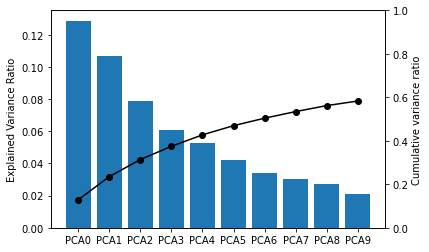

In [364]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

ax1.bar(x=np.arange(n_components),
        height=pipeline['pca'].explained_variance_ratio_,
        tick_label=pca_number)
ax1.set_ylabel('Explained Variance Ratio')

ax2.plot(np.arange(n_components), np.cumsum(pipeline['pca'].explained_variance_ratio_), 'ko-')
ax2.set_ylabel('Cumulative variance ratio')
ax2.set_ylim(0,1)
plt.show()

In [365]:
pca_x = pd.DataFrame(data=pipeline.transform(x),columns=['PCA'+str(n) for n in range(n_components)])
#pca_x['class'] = y.values
pca_x.head()

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9
0,7.795689,-3.981357,7.614501,-0.914429,0.839677,-5.781647,0.547712,4.911597,-7.716510,-1.638187
1,9.520111,2.003501,-3.048900,0.396006,-9.618008,2.423220,4.489959,-3.598765,-13.497428,-3.204622
2,18.234552,-16.813590,-2.491856,6.493757,-9.955080,-5.612142,1.087142,4.036921,-2.548712,2.092863
3,10.286900,7.648897,14.066664,3.064600,0.421877,-0.303540,4.737572,4.817920,-2.084214,1.850268
4,-1.283137,13.695249,0.252137,-6.376443,-2.475342,-5.463758,1.812244,4.416306,-2.984857,-2.810191


In [366]:
pca_x

,PCA0,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9
0,7.795689,-3.981357,7.614501,-0.914429,0.839677,-5.781647,0.547712,4.911597,-7.716510,-1.638187
1,9.520111,2.003501,-3.048900,0.396006,-9.618008,2.423220,4.489959,-3.598765,-13.497428,-3.204622
2,18.234552,-16.813590,-2.491856,6.493757,-9.955080,-5.612142,1.087142,4.036921,-2.548712,2.092863
3,10.286900,7.648897,14.066664,3.064600,0.421877,-0.303540,4.737572,4.817920,-2.084214,1.850268
4,-1.283137,13.695249,0.252137,-6.376443,-2.475342,-5.463758,1.812244,4.416306,-2.984857,-2.810191
...,...,...,...,...,...,...,...,...,...,...
1494,-13.663646,-3.765446,1.438271,-1.768864,1.635128,0.646865,-2.165015,-2.080474,-3.051794,0.787389
1495,-5.783407,-7.564021,0.723669,-0.807846,-5.912285,0.048073,2.570110,-1.431618,-1.732858,2.346827
1496,-7.816674,-7.383953,2.012563,1.067230,-3.243355,5.783603,-0.835627,-0.562764,-0.082846,-0.563061
1497,-6.744628,-8.520414,-1.042423,0.675761,-2.716728,9.381813,-2.512672,-0.816197,-1.054799,2.648671


In [368]:
total = 0
for i in range(6):
    total += len(pca_x[y==i])
    num = len(pca_x[y==i])
    print(f'class {i}: {num}')
print(f'total  : {total}')

class 0: 86
class 1: 87
class 2: 903
class 3: 193
class 4: 216
class 5: 14
total  : 1499


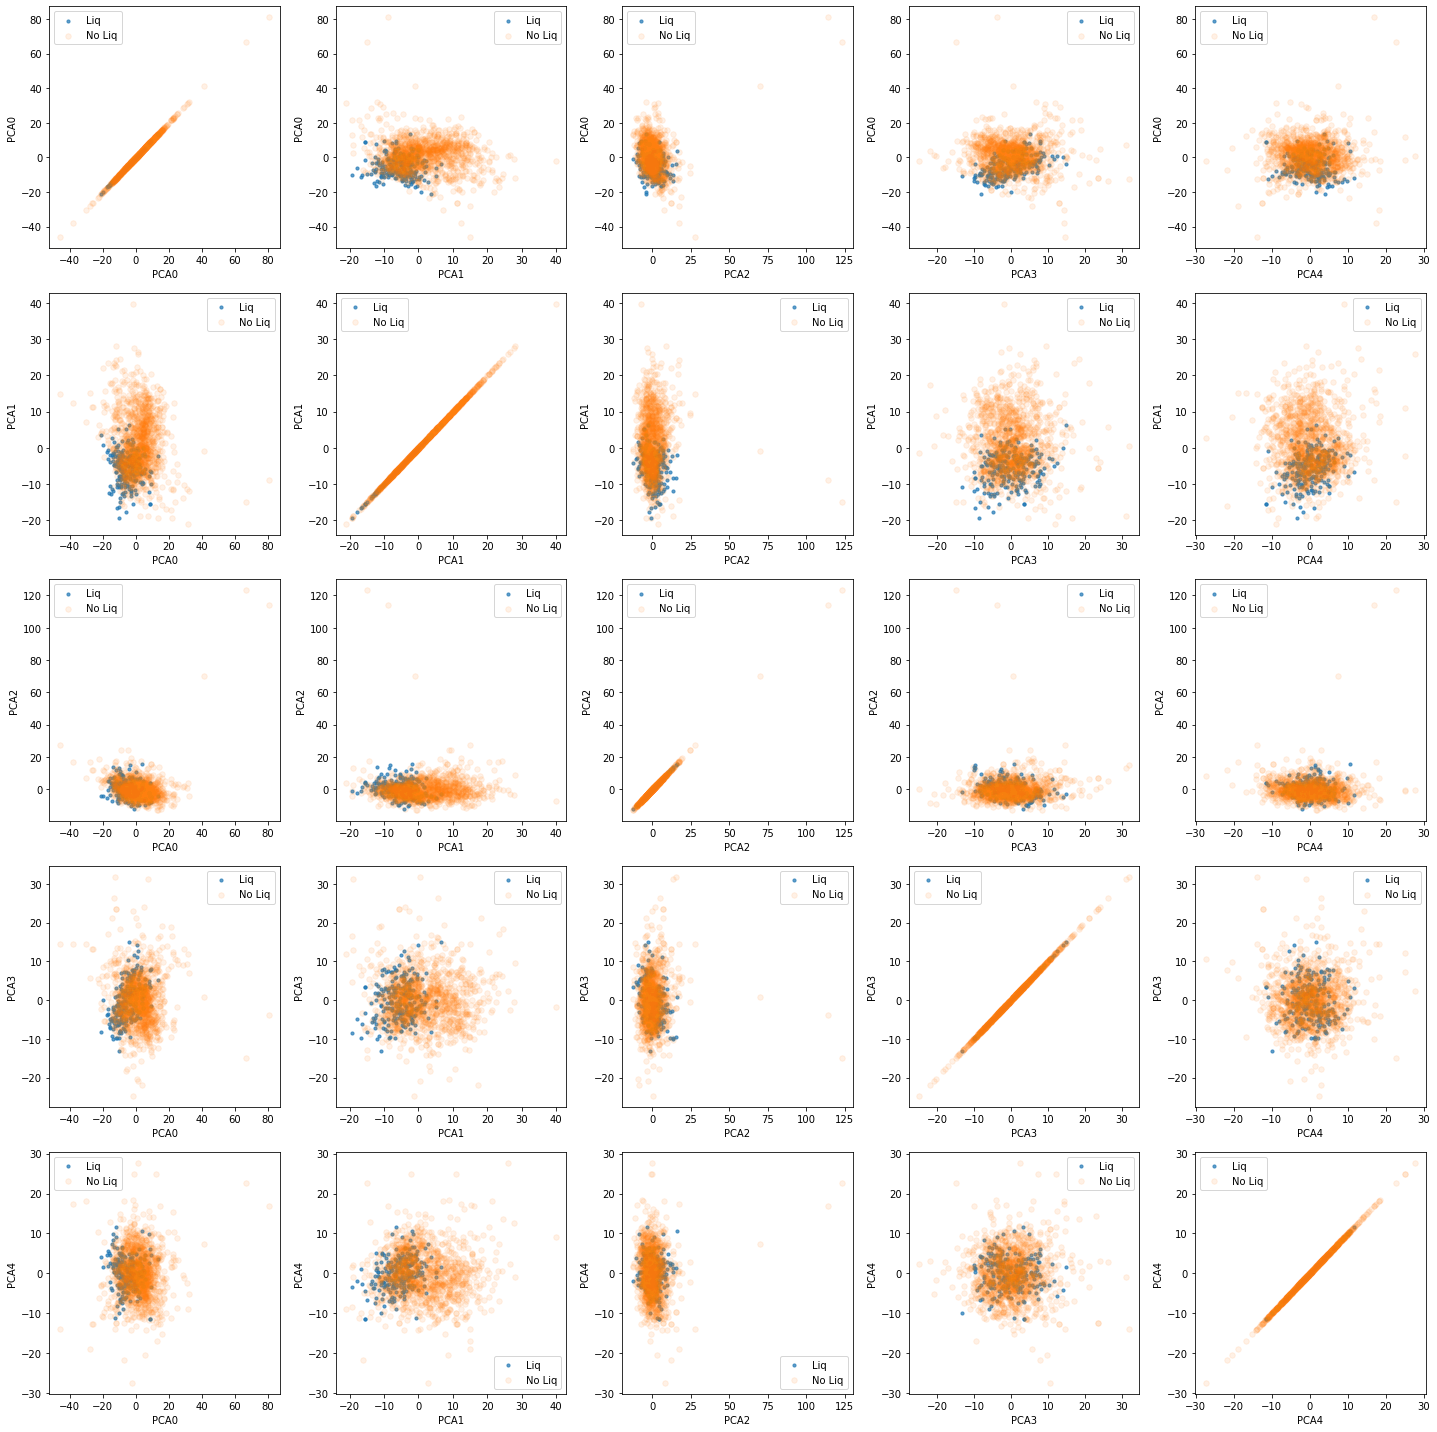

In [384]:
mask = y>3
fig, axes = plt.subplots(5,5, figsize=(20,20))
for i in range(5):
    for j in range(5):
        L = axes[j,i].scatter(x=pca_x.iloc[:,i][mask],s=10,alpha=0.7, y=pca_x.iloc[:,j][mask])
        Lnot = axes[j,i].scatter(x=pca_x.iloc[:,i][~mask],s=30,alpha=0.1, y=pca_x.iloc[:,j][~mask])
        axes[j,i].legend([L,Lnot], ['Liq', 'No Liq'])
        axes[j,i].set_xlabel(pca_x.columns[i])
        axes[j,i].set_ylabel(pca_x.columns[j])
plt.tight_layout()
#plt.savefig('PCA5by5_liq.png')

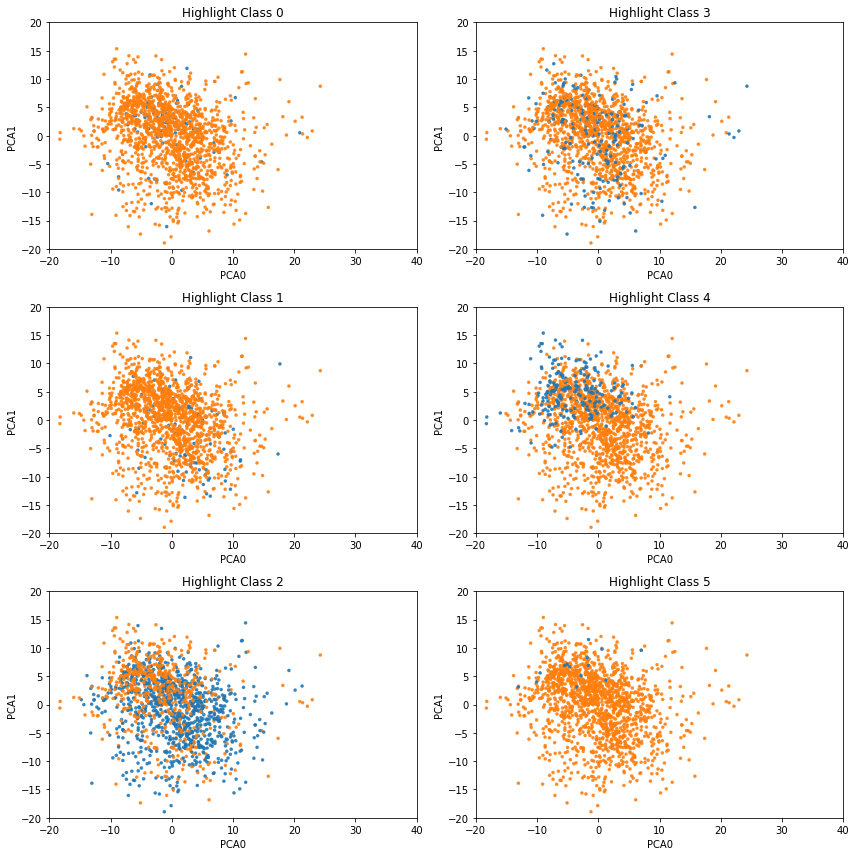

In [97]:
fig, axes = plt.subplots(3,2, figsize=(12,12))
#markers = {1: ".", 0: "."}
for i in range(6):
    pca_df['class'] = data['class'].values!=i
    sns.scatterplot(data=pca_df, x="PCA0", y="PCA1", hue='class',legend=False, alpha=0.9, s=10, edgecolor=None, ax=axes[i%3,i//3])
    axes[i%3,i//3].set_xlim(-20,40)
    axes[i%3,i//3].set_ylim(-20,20)
    axes[i%3,i//3].set_title('Highlight Class '+str(i))
plt.tight_layout()
#plt.savefig('highlight.png')

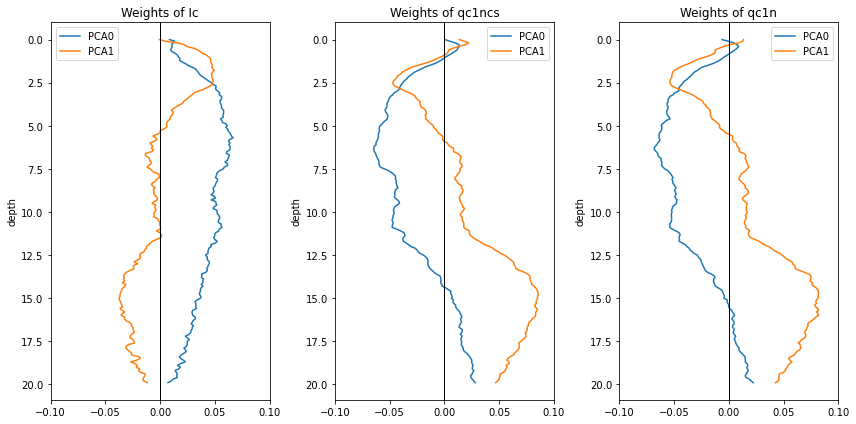

In [382]:
fig, axes = plt.subplots(1,3, figsize=(12,6))
depth = np.arange(200)/10

axes[0].plot(df_pca.iloc[0,:200].values,depth, label='PCA0')
axes[0].plot(df_pca.iloc[1,:200].values,depth, label='PCA1')
axes[0].set_ylabel('depth')
axes[0].set_title('Weights of Ic')
axes[0].set_xlim(-0.1, 0.1)
axes[0].invert_yaxis()
axes[0].legend(['PCA0','PCA1'])
axes[0].axvline(x=0, color='k', linestyle='-', lw=1)

axes[1].plot(df_pca.iloc[0,200:400].values,depth, label='PCA0')
axes[1].plot(df_pca.iloc[1,200:400].values,depth, label='PCA1')
axes[1].set_ylabel('depth')
axes[1].set_title('Weights of qc1ncs')
axes[1].set_xlim(-0.1, 0.1)
axes[1].invert_yaxis()
axes[1].legend(['PCA0','PCA1'])
axes[1].axvline(x=0, color='k', linestyle='-', lw=1)

axes[2].plot(df_pca.iloc[0,400:600].values,depth, label='PCA0')
axes[2].plot(df_pca.iloc[1,400:600].values,depth, label='PCA1')
axes[2].set_ylabel('depth')
axes[2].set_title('Weights of qc1n')
axes[2].set_xlim(-0.1, 0.1)
axes[2].invert_yaxis()
axes[2].legend(['PCA0','PCA1'])
axes[2].axvline(x=0, color='k', linestyle='-', lw=1)

plt.tight_layout()
plt.savefig('PCA_coeff.png')

In [395]:
df_pca.iloc[0:2, -4:]

,Normalized_GWT,mean_qc1ncs,mean_qc1n,mean_Ic
PCA0,0.015490,-0.054506,-0.082939,0.083366
PCA1,-0.014537,0.068841,0.056246,0.004290


## plot in Ic-qc1ncs and Ic-qc1n space

## Lateral Spreading

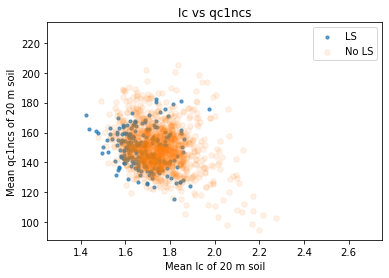

In [399]:
LS = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']>3], y=data.loc[:,'mean_qc1ncs'][data['class']>3], s=10,alpha=0.7)
LSnot = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']<=3], y=data.loc[:,'mean_qc1ncs'][data['class']<=3], s=30,alpha=0.1)
plt.legend([LS, LSnot],['LS', 'No LS'])
plt.xlim(1.25,2.75)
plt.xlabel('Mean Ic of 20 m soil')
plt.ylabel('Mean qc1ncs of 20 m soil')
plt.title('Ic vs qc1ncs')
plt.savefig('LS_ic_qc1ncs.png')

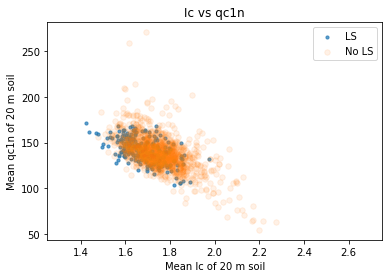

In [400]:
LS = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']>3], y=data.loc[:,'mean_qc1n'][data['class']>3], s=10,alpha=0.7)
LSnot = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']<=3], y=data.loc[:,'mean_qc1n'][data['class']<=3], s=30,alpha=0.1)
plt.legend([LS, LSnot],['LS', 'No LS'])
plt.xlim(1.25,2.75)
plt.xlabel('Mean Ic of 20 m soil')
plt.ylabel('Mean qc1n of 20 m soil')
plt.title('Ic vs qc1n')
plt.savefig('LS_ic_qc1n.png')

## Liquefaction

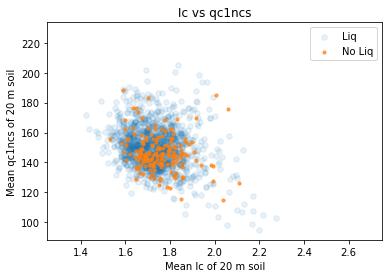

In [401]:
L = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']>1], y=data.loc[:,'mean_qc1ncs'][data['class']>1], s=30,alpha=0.1)
Lnot = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']<=1], y=data.loc[:,'mean_qc1ncs'][data['class']<=1], s=10,alpha=0.7)
plt.legend([L, Lnot],['Liq', 'No Liq'])
plt.xlim(1.25,2.75)
plt.xlabel('Mean Ic of 20 m soil')
plt.ylabel('Mean qc1ncs of 20 m soil')
plt.title('Ic vs qc1ncs')
plt.savefig('Liq_ic_qc1ncs.png')

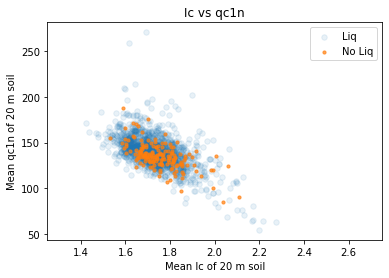

In [402]:
L = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']>1], y=data.loc[:,'mean_qc1n'][data['class']>1], s=30,alpha=0.1)
Lnot = plt.scatter(x=data.loc[:,'mean_Ic'][data['class']<=1], y=data.loc[:,'mean_qc1n'][data['class']<=1], s=10,alpha=0.7)
plt.legend([L, Lnot],['Liq', 'No Liq'])
plt.xlim(1.25,2.75)
plt.xlabel('Mean Ic of 20 m soil')
plt.ylabel('Mean qc1n of 20 m soil')
plt.title('Ic vs qc1n')
plt.savefig('Liq_ic_qc1n.png')

## K-Mean

In [160]:
from sklearn.cluster import KMeans

In [275]:
'''
y = data['class'].values
x = data.drop(['class'], axis=1).values
'''

In [403]:
scaler = StandardScaler()
x = scaler.fit(x).transform(x)

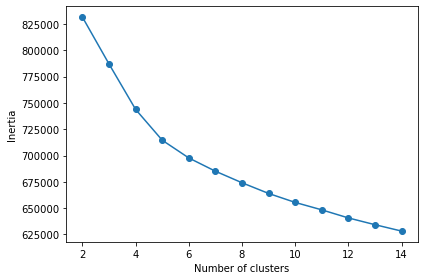

In [416]:
inertias = []
ks = list(range(2,15))
for k in ks:
    km = KMeans(n_clusters=k,random_state=0)
    km.fit(x)
    inertias.append(km.inertia_)
    

plt.plot(ks,inertias,'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.tight_layout()
plt.savefig('Inertia.png')

In [434]:
n_clusters = 2
k_means = KMeans(n_clusters=n_clusters, random_state=0)

In [435]:
x.shape

(1499, 604)

In [436]:
k_means.fit(x)

KMeans(n_clusters=2, random_state=0)

In [437]:
labels=k_means.labels_
print(len(labels),set(labels))

1499 {0, 1}


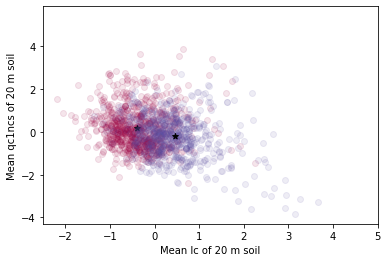

In [438]:
# generate colors for different clusters
colors = plt.cm.Spectral(np.linspace(0,1,n_clusters))
centers = k_means.cluster_centers_

for k, col in enumerate(colors):
    center = centers[k]

    plt.scatter(x[labels==k,-1],x[labels==k,-3],
                color=col,alpha=0.1)
    
    # Plots the centroids with specified color, but with a darker outline
    plt.scatter(centers[k][-1],centers[k][-3],color='k',marker='*')
plt.xlabel('Mean Ic of 20 m soil')
plt.ylabel('Mean qc1ncs of 20 m soil')
plt.xlim(-2.5,5)
plt.savefig('kmean2.png')

In [439]:
data['Clusters'] = labels
contingency = pd.crosstab(data['class'] ,data.Clusters)
#contingency.round(2)

In [440]:
contingency

Clusters,0,1
class,,
0.0,59,27
1.0,28,59
2.0,405,498
3.0,109,84
4.0,202,14
5.0,13,1


In [432]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(contingency)
print (pd.DataFrame(expected))
print('statistic = {}, '
      'p-value = {}, '
      'degress of freedom = {}'.format(stat,p,dof))

            0         1           2
0   42.168112  0.172115   43.659773
1   42.658439  0.174116   44.167445
2  442.765177  1.807205  458.427618
3   94.633089  0.386258   97.980654
4  105.910607  0.432288  109.657105
5    6.864576  0.028019    7.107405
statistic = 193.83371362865313, p-value = 3.111988146603261e-36, degress of freedom = 10


## VAE